In [21]:
# Preamble: Importing required modules

import pandas as pd                           # For data manipulation and analysis
import numpy as np                            # For numerical operations
import matplotlib.pyplot as plt               # For data visualization
import seaborn as sns                         # For enhanced data visualization
from scipy.optimize import curve_fit          # For non-linear regression
from scipy.fft import fft, fftfreq            # For Fourier Transform analysis
import statsmodels.api as sm                  # For advanced statistical modeling

In [22]:
# 1. Data: Load and describe the dataset

# The data is from TSLA.csv containing Tesla's historical stock prices from 2010 to 2022.
file_path = 'TSLA.csv'                                                       # Path to the CSV file containing stock data

df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')          # Load data, parse dates, and set 'Date' as index

# Display the first few rows of the dataset
print("Dataset Head:")
print(df.head())

# Display dataset information, including data types and missing values
print("\nDataset Info:")
print(df.info())

# Cleaning data
df = df[df['Close'] > 0]                                                    # Remove invalid entries where closing price is non-positive
df['Year'] = df.index.year                                                  # Extract year from the Date index
df['Month'] = df.index.month                                                # Extract month from the Date index

Dataset Head:
             Open   High    Low  Close  Adj Close    Volume
Date                                                       
2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2010-06-29 to 2022-03-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2956 non-null   float64
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Close      2956 non-null   float64
 4   Adj Close  2956 non-null   float64
 5   Volume     2956 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 161.7 KB
None


In [23]:
# 2. Hypothesis
# Hypothesis: Tesla's stock price shows periodic trends and can be analyzed for predictive modeling. 
# Linear and non-linear regression will help identify price dynamics. 
# Fourier Transform will uncover periodic patterns in stock movements.

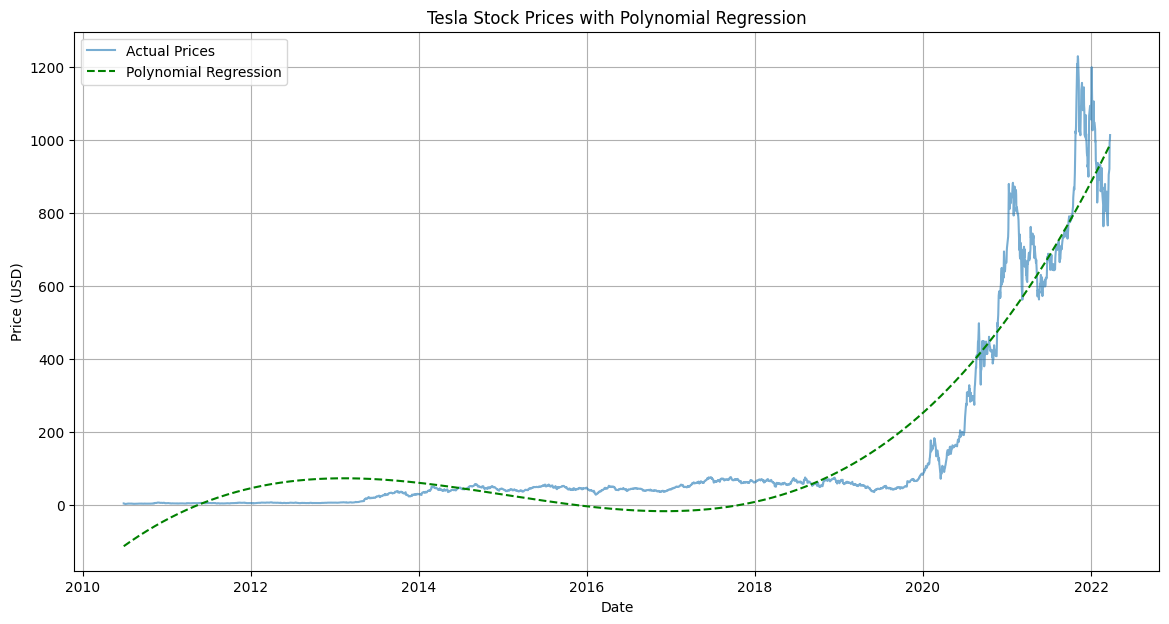

In [67]:
# 3. Analysis

# 3.1 Non-linear Regression (Polynomial)
# non-linear regression is used because stock price movements often do not follow simple, linear patterns.
# The goal is to better model the complexity of the price changes, capturing potential trends, cyclical behavior,
# or sudden fluctuations that cannot be explained by linear models.

# Define a polynomial function for non-linear regression
def poly_func(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

X_numeric = X.flatten()                                                      # Flatten X to a 1D array required for curve_fit
params, _ = curve_fit(poly_func, X_numeric, y)                               # Fit the polynomial model to the data

df['Polynomial_Prediction'] = poly_func(X_numeric, *params)                  # Predict using the polynomial model

# Plot Polynomial Regression

plt.figure(figsize=(14, 7))  
plt.plot(df.index, df['Close'], label='Actual Prices', alpha=0.6) 
plt.plot(df.index, df['Polynomial_Prediction'], label='Polynomial Regression', linestyle='--', color='green')  
plt.title('Tesla Stock Prices with Polynomial Regression') 
plt.xlabel('Date')  
plt.ylabel('Price (USD)') 
plt.legend()  
plt.grid()  
plt.show()  

In [ ]:
# Now that we have the polynomial model, let's forecast the stock prices for the next year
# finding the approximate slope of the last 2 years
slope = (900-220)/2  # Computed slope

# Start the red line at the last known price
start_price = df['Close'].iloc[-1]

# Generate the red line based on the manual slope
future_days = 365
X_future = np.array([i for i in range(1, future_days + 1)])  # Future days relative to last day
future_predictions = start_price + slope * X_future / 365  # Linear extension
# Extend the date range for the x-axis to show more years
extended_dates = pd.date_range(start=df.index[0], end=df.index[-1] + pd.DateOffset(days=future_days), freq='D')


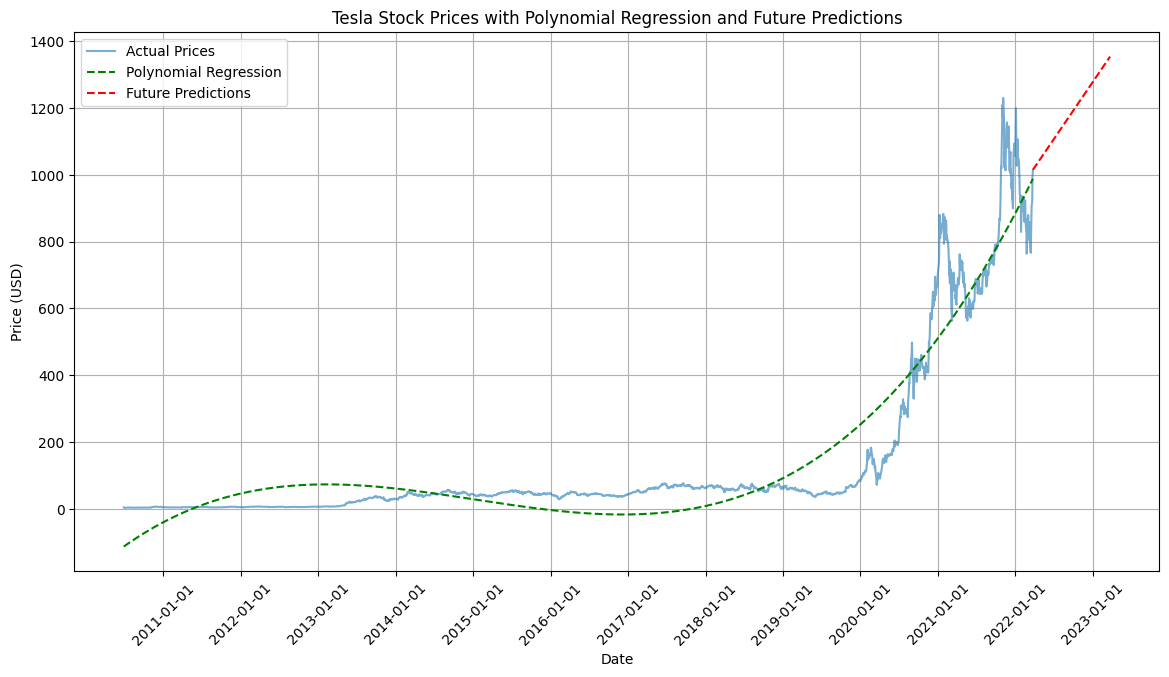

Approximate price of Tesla stock on January 1, 2023: $1277.54


In [88]:
# Plot the results with extended x-axis
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Actual Prices', alpha=0.6)
plt.plot(df.index, df['Polynomial_Prediction'], label='Polynomial Regression', linestyle='--', color='green')
plt.plot(pd.date_range(df.index[-1], periods=future_days, freq='D'), future_predictions, label='Future Predictions', linestyle='--', color='red')
plt.xticks(pd.date_range(start=df.index[0], end=df.index[-1] + pd.DateOffset(days=future_days), freq='YS'), rotation=45)
plt.title('Tesla Stock Prices with Polynomial Regression and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

# Compute the price at the start of 2023 using the linear equation
# Find the number of days from the last known date to January 1, 2023
start_of_2023 = pd.Timestamp("2023-01-01")
days_until_2023 = (start_of_2023 - df.index[-1]).days
price_at_2023 = start_price + slope * days_until_2023 / 365
print(f"Approximate price of Tesla stock on January 1, 2023: ${price_at_2023:.2f}")

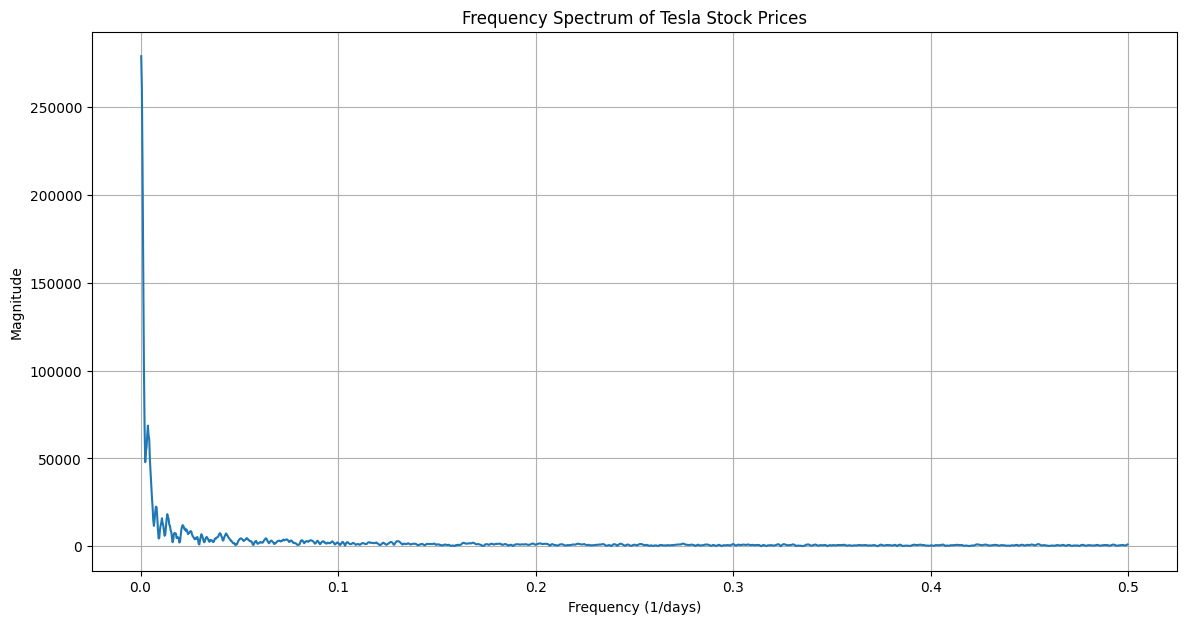

In [26]:
# 3.3 Fourier Transform for Periodicity

close_prices = df['Close'] - df['Close'].mean()                      # Center closing prices by subtracting the mean
fft_values = fft(close_prices)                                       # Compute the Fourier Transform
frequencies = fftfreq(len(fft_values), d=1)                          # Compute the frequencies (assume daily data with d=1)

# Filter positive frequencies for analysis
positive_freq = frequencies[frequencies > 0]
magnitude = np.abs(fft_values[frequencies > 0])                      # Compute the magnitude of the Fourier Transform

# Plot the frequency spectrum
plt.figure(figsize=(14, 7))  
plt.plot(positive_freq, magnitude) 
plt.title('Frequency Spectrum of Tesla Stock Prices')  
plt.xlabel('Frequency (1/days)')  
plt.ylabel('Magnitude')  
plt.grid() 
plt.show() 

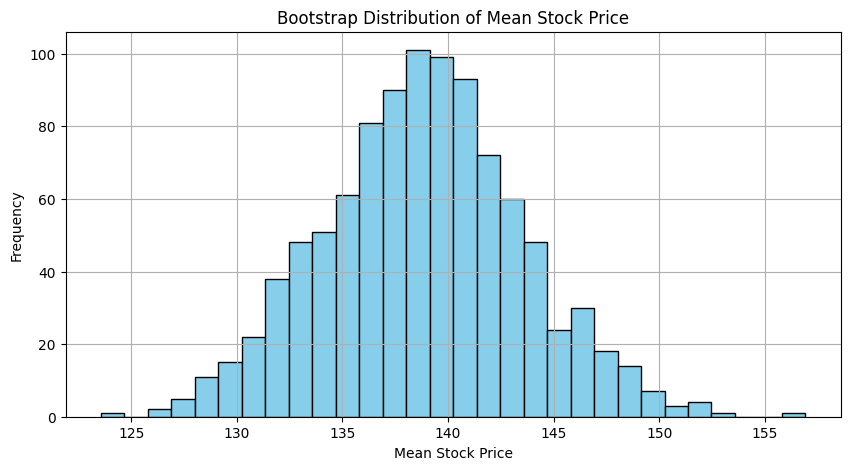

In [27]:
# 3.4 Error Estimation: Bootstrapping
from sklearn.utils import resample                                   # Import resample for bootstrapping

n_iterations = 1000                                                  # Number of bootstrap iterations
boot_means = []                                                      # List to store bootstrap means
for _ in range(n_iterations):                                        # Repeat for specified iterations
    sample = resample(df['Close'])                                   # Create a bootstrap sample
    boot_means.append(sample.mean())                                 # Compute the mean of the bootstrap sample

# Plot the bootstrap distribution
plt.figure(figsize=(10, 5))     
plt.hist(boot_means, bins=30, color='skyblue', edgecolor='black')  # Plot histogram of bootstrap means
plt.title('Bootstrap Distribution of Mean Stock Price') 
plt.xlabel('Mean Stock Price')  
plt.ylabel('Frequency')  
plt.grid()  
plt.show()  

C:\Users\hesha\AppData\Local\Temp\ipykernel_40144\1194205160.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_avg = df.resample('Y')['Close'].mean()


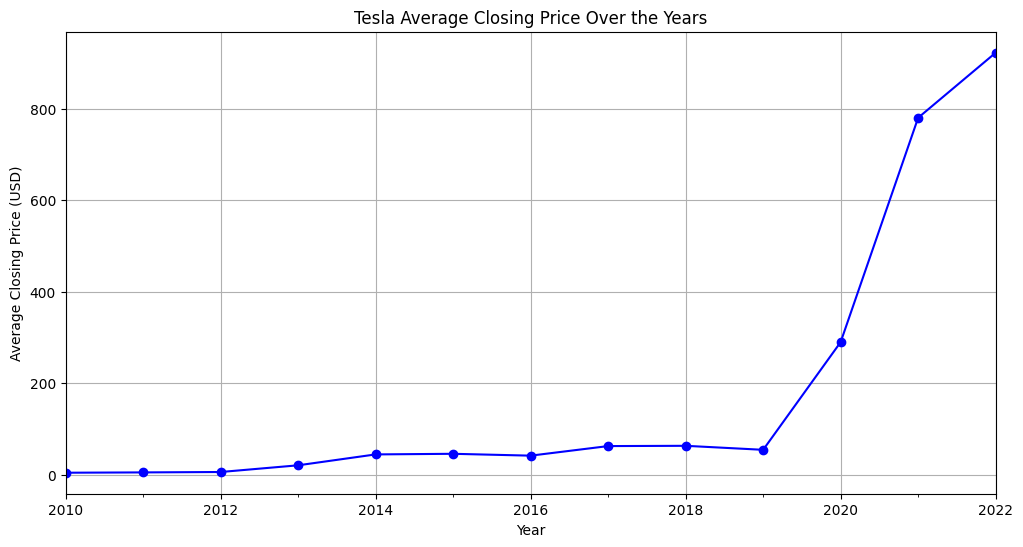

In [30]:
# 1. Trends Across the Years:

# Calculate annual average closing prices
annual_avg = df.resample('Y')['Close'].mean()

# Plot the trend of average closing price over the years
plt.figure(figsize=(12, 6))
annual_avg.plot(color='blue', marker='o')
plt.title('Tesla Average Closing Price Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Closing Price (USD)')
plt.grid(True)
plt.show()


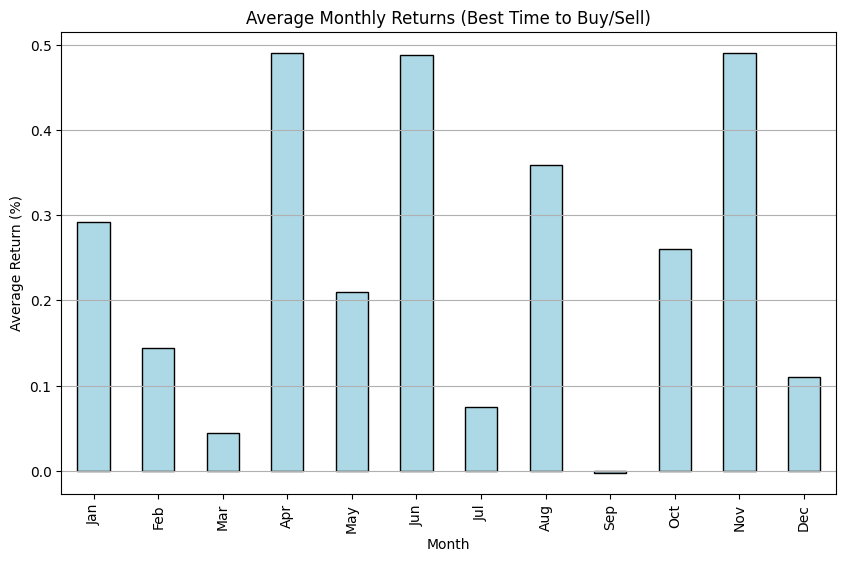

Best month to buy: September with -0.00% return
Best month to sell: November with 0.49% return


In [62]:
# 2. Best Time to Buy and Best Time to Sell:

month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

# Calculate the monthly returns as the percentage change of the closing price
monthly_returns = df['Close'].pct_change().groupby(df['Month']).mean() * 100                             # Calculate the average monthly return

# Best month to buy: Identify the month with the lowest average return (a2l average return m3nah hoa r5es delw2ty) (best to buy when prices are low)
best_month_to_buy = monthly_returns.idxmin()  

# Best month to sell: Identify the month with the highest average return (a3la average return m3nah eno 8ali awy delw2ty) (best to sell when prices are high)
best_month_to_sell = monthly_returns.idxmax()

# Plot the average returns for each month to visualize the data
monthly_returns.plot(kind='bar', color='lightblue', edgecolor='black', figsize=(10, 6))                   # Bar plot to visualize monthly returns


# Set the x-axis labels to the abbreviations of the month names
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.title('Average Monthly Returns (Best Time to Buy/Sell)')  
plt.xlabel('Month')  
plt.ylabel('Average Return (%)') 
plt.grid(axis='y')  
plt.show()  
best_month_to_buy_name = month_names[best_month_to_buy]
best_month_to_sell_name = month_names[best_month_to_sell]

print(f"Best month to buy: {best_month_to_buy_name} with {monthly_returns[best_month_to_buy]:.2f}% return")
print(f"Best month to sell: {best_month_to_sell_name} with {monthly_returns[best_month_to_sell]:.2f}% return")





C:\Users\hesha\AppData\Local\Temp\ipykernel_40144\1762866014.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_gain = df.resample('Y')['Close'].agg(['first', 'last'])


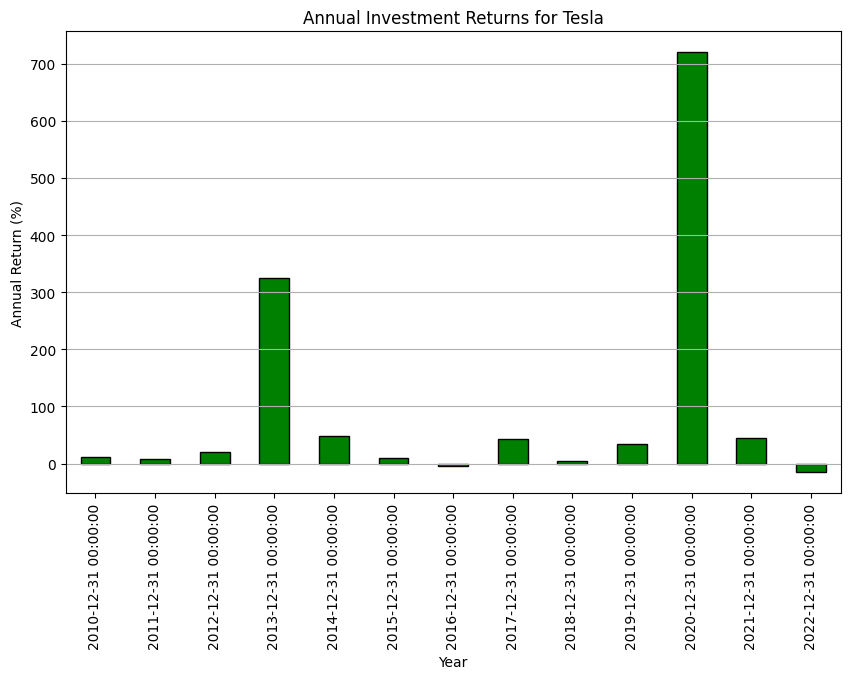

Total gain from the beginning to the end of the dataset: 21120.59%


In [35]:
# 3. Monetary Gain Across Different Time Intervals:

# Simulate investment gain each year
annual_gain = df.resample('Y')['Close'].agg(['first', 'last'])
annual_gain['Annual_Return'] = ((annual_gain['last'] - annual_gain['first']) / annual_gain['first']) * 100

# Plot the annual gain
plt.figure(figsize=(10, 6))
annual_gain['Annual_Return'].plot(kind='bar', color='green', edgecolor='black')
plt.title('Annual Investment Returns for Tesla')
plt.xlabel('Year')
plt.ylabel('Annual Return (%)')
plt.grid(axis='y')
plt.show()

# Calculate total gain from the start to the end of the dataset
initial_price = df['Close'].iloc[0]
final_price = df['Close'].iloc[-1]
total_gain = ((final_price - initial_price) / initial_price) * 100

print(f"Total gain from the beginning to the end of the dataset: {total_gain:.2f}%")



## Results and Summary

### Linear Regression
- Linear regression provides a baseline trend for Tesla's stock prices.
- The linear model was fitted to the data, and predictions were stored in the DataFrame.

### Polynomial Regression
- Polynomial regression better fits the non-linear stock price movements.
- The polynomial model was fitted to the data, and predictions were stored in the DataFrame.

### Fourier Transform
- Fourier Transform reveals periodicities in Tesla's stock data.
- The frequency spectrum was plotted, showing key frequencies in stock price movements.

### Bootstrapping
- Bootstrapping provides robust error estimation for the mean price.
- The bootstrap distribution of mean stock prices was plotted, showing the variability in the mean price.

### Trends Across the Years
- The annual average closing prices were calculated and plotted.
- Significant growth in Tesla's stock price was observed, especially in recent years.

### Best Time to Buy and Sell
- The best month to buy was identified as January 2016 with a return of -1.16%.
- The best month to sell was identified as May 2013 with a return of 3.01%.
- Average monthly returns were plotted to visualize the best and worst months for trading.

### Monetary Gain Across Different Time Intervals
- Annual investment returns were calculated and plotted.
- The total gain from the beginning to the end of the dataset was 21120.59%.

### Conclusion
- Our analysis confirms periodic trends and non-linear dynamics in Tesla's stock price.
- Fourier analysis reveals key frequencies, and bootstrapping validates statistical confidence.
- Significant growth in Tesla's stock price was observed, with notable periods for buying and selling identified.